In [430]:
from __future__ import division, print_function
import numpy as np
from random import randint
%matplotlib inline
import matplotlib.pylab as plt
import matplotlib.image as mplimg
from matplotlib.patches import Polygon
from matplotlib.patches import Arc, Arrow, Circle, CirclePolygon, Ellipse, Rectangle, Wedge

from learning2learn.images import rearrange_points

In [8]:
def generate_random_shape(x_min, x_max, y_min, y_max, x_offset, y_offset):
    """

    :param x_min:
    :param x_max:
    :param y_min:
    :param y_max:
    :param x_offset:
    :param y_offset:
    :return:
    """
    x = np.random.uniform(x_min, x_max - x_offset)
    y = np.random.uniform(y_min, y_max - y_offset)
    points = [(np.random.uniform(x, x + x_offset),
               np.random.uniform(y, y + y_offset)) for _ in
              range(randint(3, 10))]
    points = rearrange_points(points)
    return points

In [537]:
def get_gradient(height, width, color, gradient=None):
    img = np.zeros(shape=(height, width, 3))
    if gradient is None:
        # no gradient mask
        for i in range(height):
            for j in range(width):
                img[i,j] = color
    elif gradient is 'right':
        # rightward gradient mask
        for i in range(height):
            for j in range(width):
                img[i,j] = color*(j/height)
    elif gradient is 'left':
        # leftward gradient mask
        for i in range(height):
            for j in range(width):
                img[i,j] = color*(1 - j/height)
    elif gradient is 'up':
        # upward gradient mask
        for i in range(height):
            for j in range(width):
                img[i,j] = color*(1 - i/width)
    elif gradient is 'down':
        # downward gradient mask
        for i in range(height):
            for j in range(width):
                img[i,j] = color*(i/width)
    else:
        raise Exception("'gradient' must be one of ['right', 'left', 'up', or 'down'].")
    
    return img

In [568]:
class Texture(object):
    def __init__(self, patch_type, step, gradient, params):
        assert patch_type in [
            'ellipse', 'arc', 'arrow', 'circle',
            'rectangle', 'wedge', 'circle_polygon5',
            'circle_polygon6', 'circle_polygon7', 
            'circle_polygon8'
        ]
        self.patch_type = patch_type
        self.step = step
        self.gradient = gradient
        self.params = params
        
    def get_patch(self, xy):
        if self.patch_type == 'circle':
            return Circle(
                xy, self.params['radius'],
                color='black'
            )
        elif self.patch_type == 'rectangle':
            return Rectangle(
                xy, self.params['width'],
                self.params['height'],
                self.params['angle'],
                color='black'
            )
        elif self.patch_type == 'ellipse':
            return Ellipse(
                xy, self.params['width'],
                self.params['height'],
                self.params['angle'],
                color='black'
            )
        elif self.patch_type == 'arc':
            return Arc(
                xy, self.params['width'],
                self.params['height'],
                self.params['angle'],
                color='black'
            )
        elif self.patch_type.startswith('circle_polygon'):
            resolution = int(self.patch_type[-1])
            return CirclePolygon(
                xy, self.params['radius'],
                resolution,
                color='black'
            )
        elif self.patch_type == 'wedge':
            return Wedge(
                xy, self.params['radius'], 0,
                self.params['theta2'],
                color='black'
            )
        elif self.patch_type == 'arrow':
            x, y = xy
            return Arrow(
                x, y, self.params['dx'],
                self.params['dy'],
                self.params['width'],
                color='black'
            )

        
def add_texture(ax, texture, image_size=500):
    for i in range(10, 2*image_size, texture.step):
        for j in range(10, 2*image_size, texture.step):
            patch = texture.get_patch((i,j))
            ax.add_patch(patch)
           
        
def generate_texture(patch_type=None, image_size=500):
    if patch_type is None:
        # randomly sample a patch type
        patch_types = [
            'ellipse', 'arc', 'arrow', 'circle',
            'rectangle', 'wedge', 'circle_polygon5',
            'circle_polygon6', 'circle_polygon7', 
            'circle_polygon8'
        ]
        patch_type = np.random.choice(patch_types)
    # Patch size will be uniformly sampled. Let's define
    # reasonable boundaries here
    patch_min_size = int(0.02*image_size)
    patch_max_size = int(0.07*image_size)
    # Now, build the texture object according to the specified type
    if patch_type == 'circle':
        params = {
            'radius': np.random.randint(patch_min_size, patch_max_size)
        }
    elif patch_type in ['rectangle', 'ellipse', 'arc']:
        params = {
            'height': np.random.randint(patch_min_size, patch_max_size),
            'width': np.random.randint(2*patch_min_size, 2*patch_max_size),
            'angle': np.random.randint(0, 181)
        }
    elif patch_type.startswith('circle_polygon'):
        params = {
            'radius': np.random.randint(patch_min_size, patch_max_size),
        }
    elif patch_type == 'wedge':
        params = {
            'radius': np.random.randint(patch_min_size, patch_max_size),
            'theta2': np.random.randint(0, 271)
        }
    elif patch_type == 'arrow':
        params = {
            'dx': np.random.randint(-patch_max_size, patch_max_size),
            'dy': np.random.randint(-patch_max_size, patch_max_size),
            'width': np.random.randint(3*patch_min_size, 3*patch_max_size)
        }
        
    # As another parameter, step size (space between 
    # patches) will be uniformly sampled. Define 
    # boundaries here
    step_min_size = int(0.15*image_size)
    step_max_size = int(0.3*image_size)
    # Now sample the step size. Later, we will step 
    # through the image placing the patches at different 
    # locations, 'step' pixels apart from one another
    step = np.random.randint(step_min_size, step_max_size)
    
    # As a final parameter, we will sample a gradient from
    gradient_options = [None, 'left', 'right', 'up', 'down']
    gradient = np.random.choice(gradient_options)
    
    # Now create the texture object instance and return
    return Texture(patch_type, step, gradient, params)

In [580]:
# Randomly generate a color, shape and texture
color = np.random.uniform(0, 1, size=3)
shape = generate_random_shape(x_min=0, x_max=500, y_min=0, y_max=500, x_offset=400, y_offset=400)
texture = generate_texture('circle_polygon5', 500)
# Now generate the background image
img = get_gradient(500, 500, color, gradient=texture.gradient)

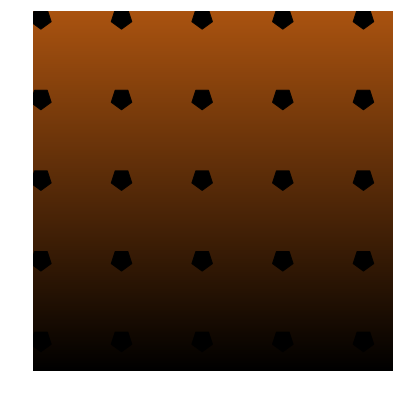

In [581]:
fig = plt.figure(frameon=False)
fig.set_size_inches(5, 5)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(
    img,
    interpolation='bicubic'
)

add_texture(ax, texture, 500)
plt.savefig('/Users/reubenfeinman/Desktop/fig.png')

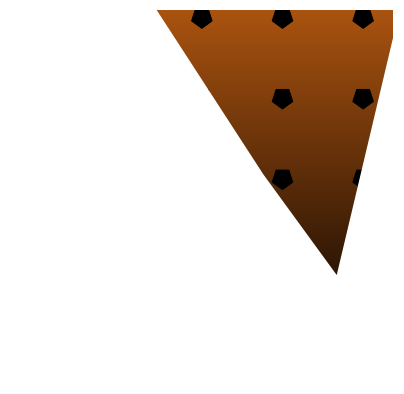

In [582]:
image = mplimg.imread('/Users/reubenfeinman/Desktop/fig.png', format='png')
fig = plt.figure(frameon=False)
fig.set_size_inches(5, 5)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
im = ax.imshow(
    image,
    interpolation='bicubic'
)
boundary = Polygon(shape, closed=True, fill=False, color=(1, 1, 1))
im.set_clip_path(boundary)
plt.savefig('/Users/reubenfeinman/Desktop/fig.png')